[nltk_data] Downloading package punkt to
[nltk_data]     /Users/robinwoodfamily/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/robinwoodfamily/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/var/folders/6_/x10j3qv524qdjmnwk9l24_940000gn/T/ipykernel_6781/1171444370.py:242: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


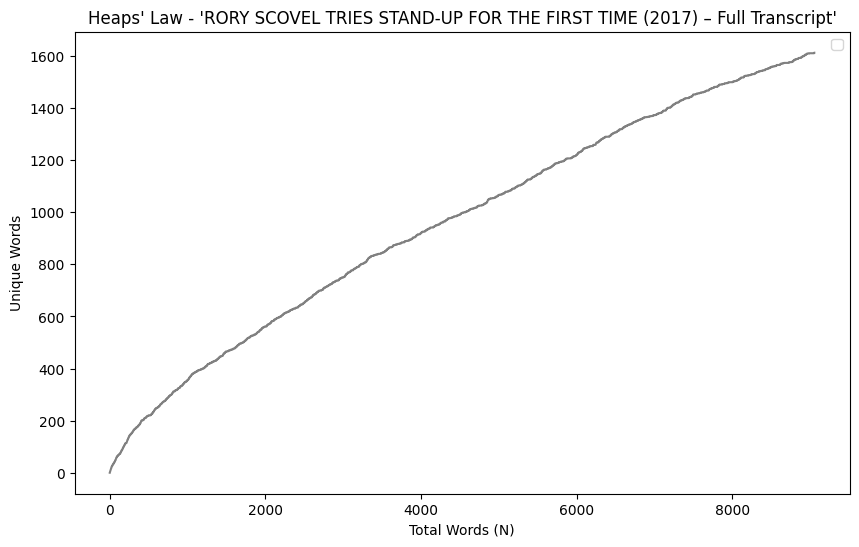

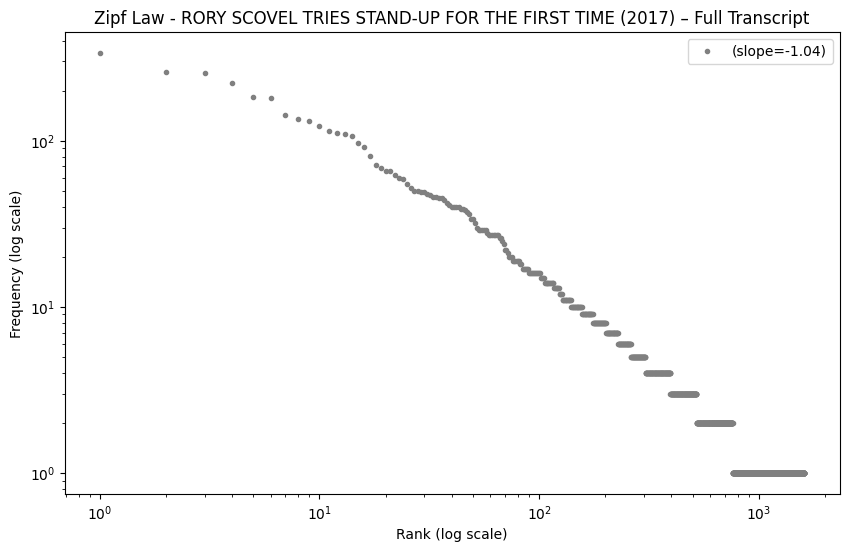

In [24]:
import pandas as pd
import requests
import json
import nltk
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
from nltk import download
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress

download('punkt')
download('stopwords')

url = 'https://raw.githubusercontent.com/marobinette/pocs/main/project/comedy_data_10_31.csv'

df = pd.read_csv(url)
df = df[['title', 'length', 'transcript']]

def export_comedian_word_data(word_data, comedian):
    """
    Exports the word data for a specific comedian to a CSV file.
    
    Parameters:
    - word_data (DataFrame): DataFrame containing words, counts, total unique words, and probabilities.
    - comedian (str): Name of the comedian to label the CSV file.
    """
    word_data = word_data.rename(columns={'word': 'types'})
    word_data = word_data[['types', 'counts', 'total_unique', 'probs']]    
    filename = f"{comedian}.csv"
    word_data.to_csv(filename, index=False)
    print(f"Data exported to {filename} successfully.")

def get_word_data(words):
    """
    Generates word frequency data including counts and probabilities.
    
    Parameters:
    - words (list): List of words to analyze for frequency and probability.
    
    Returns:
    - DataFrame: DataFrame with word counts, probabilities, and total unique word count.
    """
    word_data = pd.Series(words).value_counts().reset_index()
    word_data.columns = ['word', 'counts']        
    word_data['probs'] = word_data['counts'] / word_data['counts'].sum()    
    word_data['total_unique'] = len(word_data)
    word_data = word_data.sort_values(by='counts', ascending=False).reset_index(drop=True)
    
    return word_data

def tokenize_words(text, remove_stop_words = False):
    """
    Tokenizes the text into words, with an option to remove stopwords.
    
    Parameters:
    - text (str or list): Text or list of strings to tokenize.
    - remove_stop_wprds (bool): Whether to remove stopwords from the tokens.
    
    Returns:
    - list: List of tokenized words.
    """
    if isinstance(text, list):
        text = ' '.join(text)
    
    tokenizer = RegexpTokenizer(r'\w+')
    words = tokenizer.tokenize(text)  

    if remove_stop_words:
        stop_words = set(stopwords.words('english'))
        words = [word for word in words if word not in stop_words]
    
    return words

def calculate_innovation_rate(words):
    """
    Calculates the innovation rate as the ratio of unique words to the total words.
    
    Parameters:
    - words (list): List of tokenized words.
    
    Returns:
    - float: Innovation rate.
    """
    unique_words = set(words)
    total_words = len(words)
    innovation_rate = len(unique_words) / total_words if total_words > 0 else 0
    return innovation_rate

def get_innovation_rate_data(df):
    """
    Returns a DataFrame with title, innovation rate, and length of set for each comedian.
    """
    titles = []
    lengths = []  # Renamed to avoid overwriting
    innovation_rates = []

    for idx, row in df.iterrows():
        title = row['title']
        length = row['length']  # Length of the set
        transcript = row['transcript']
        
        words = tokenize_words(transcript, remove_stop_words=False)
        innovation_rate = calculate_innovation_rate(words) * 100  # Convert to percentage
        
        # Append data to lists
        titles.append(title)
        lengths.append(length)
        innovation_rates.append(innovation_rate)
    
    # Create a new DataFrame with title, length, and innovation_rate columns
    innovation_rate_df = pd.DataFrame({
        'title': titles,
        'length': lengths,  # Corrected list name here
        'innovation_rate': innovation_rates
    })

    return innovation_rate_df


def plot_zipf_distribution(df, title):
    """
    Plots the Zipf distribution for the given comedian's transcript.
    
    Parameters:
    - df (DataFrame): DataFrame containing comedy data with titles and transcripts.
    - title (str): The comedian's name for which to plot the distribution.
    """
    # Filter the dataframe for the given comedian
    transcript = df[df['title'] == title]['transcript'].values[0]
    
    # Tokenize the words
    words = tokenize_words(transcript, remove_stop_words=False)
    
    # Generate word frequency data
    word_data = get_word_data(words)
    
    # Rank the words by frequency
    word_data['rank'] = np.arange(1, len(word_data) + 1)
    
    # Log-transform rank and frequency
    log_rank = np.log10(word_data['rank'])
    log_freq = np.log10(word_data['counts'])
    
    # Perform linear regression to calculate the slope
    slope, intercept, r_value, p_value, std_err = linregress(log_rank, log_freq)
    
    # Plot the Zipf distribution (log-log scale)
    plt.figure(figsize=(10, 6))
    plt.loglog(word_data['rank'], word_data['counts'], marker=".", linestyle='none', color="grey", label=f'(slope={slope:.2f})')
    
    plt.xlabel('Rank (log scale)')
    plt.ylabel('Frequency (log scale)')
    plt.title(f'Zipf Law - {title}')
    plt.legend()
    plt.show()

def plot_innovation_rate(df):
    plt.figure(figsize=(10, 6))
    plt.scatter(innovation_rate_df['length'], innovation_rate_df['innovation_rate'], alpha=0.7)
    plt.xlabel('Length of Set')
    plt.ylabel('Innovation Rate (%)')
    plt.title('Innovation Rate vs. Length of Set')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# innovation_rate_df = get_innovation_rate_data(df)
# plot_innovation_rate(innovation_rate_df)

def get_innovation_rate_data_with_word_count(df):
    """
    Returns a DataFrame with title, innovation rate, and word count of each comedian's set.
    """
    titles = []
    word_counts = []
    innovation_rates = []

    for idx, row in df.iterrows():
        title = row['title']
        transcript = row['transcript']
        
        words = tokenize_words(transcript, remove_stop_words=False)
        word_count = len(words)
        innovation_rate = calculate_innovation_rate(words) * 100  # Convert to percentage
        
        # Append data to lists
        titles.append(title)
        word_counts.append(word_count)
        innovation_rates.append(innovation_rate)
    
    # Create a new DataFrame with title, word_count, and innovation_rate columns
    innovation_rate_df = pd.DataFrame({
        'title': titles,
        'word_count': word_counts,
        'innovation_rate': innovation_rates
    })

    return innovation_rate_df

def plot_innovation_rate_by_word_count(df):
    """
    Plots innovation rate against the number of words in each transcript.
    
    Parameters:
    - df (DataFrame): DataFrame containing title, word_count, and innovation_rate.
    """
    plt.figure(figsize=(10, 6))
    plt.scatter(df['word_count'], df['innovation_rate'], alpha=0.7)
    plt.xlabel('Transcript Length (Word Count)')
    plt.ylabel('Innovation Rate (%)')
    plt.title('Innovation Rate vs. Transcript Length')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def calculate_vocabulary_growth(words):
    """
    Calculates vocabulary size as a function of word count for a given transcript.
    Returns a list of tuples where each tuple contains the count of words and unique words.
    """
    vocab_growth = []
    unique_words = set()
    for i, word in enumerate(words, 1):
        unique_words.add(word)
        vocab_growth.append((i, len(unique_words)))
    return np.array(vocab_growth)

def plot_heaps_law(df, title):
    """Plots Heaps' Law based on vocabulary growth for a single comedy set."""
    transcript = df[df['title'] == title]['transcript'].values[0]
    words = tokenize_words(transcript, remove_stop_words=False)
    vocab_growth = calculate_vocabulary_growth(words)
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(vocab_growth[:, 0], vocab_growth[:, 1], color='grey')
    plt.xlabel("Total Words (N)")
    plt.ylabel("Unique Words")
    plt.title(f"Heaps' Law - '{title}'")
    plt.legend()
    plt.show()

plot_heaps_law(df, 'RORY SCOVEL TRIES STAND-UP FOR THE FIRST TIME (2017) – Full Transcript')


# Generate the updated DataFrame and plot
# innovation_rate_df = get_innovation_rate_data_with_word_count(df)
# plot_innovation_rate_by_word_count(innovation_rate_df)

plot_zipf_distribution(df, 'RORY SCOVEL TRIES STAND-UP FOR THE FIRST TIME (2017) – Full Transcript') 
# plot_zipf_distribution(df, 'MITCH HEDBERG: COMEDY CENTRAL SPECIAL (1999) – Full Transcript') 
# plot_zipf_distribution(df, 'Tig Notaro: Happy To Be Here (2018) – Full Transcript') 
